# `0.` IMPORTING REQUIRED LIBs

In [1]:
# base libariries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import shapiro

# preprocessing libariries
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import PolynomialFeatures

# statistics 
from statsmodels.api import OLS
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# splitting helper
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

# evaluation metric
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# warnings
import warnings
warnings.filterwarnings("ignore")

# `~` MY STATISTICS & METRICS

#### `~.0` R-Squared
$$ R^{2} = 1 - \dfrac{RSS}{TSS}$$

In [2]:
def r_squared(actual, predicted):
    actual_mean = np.mean(actual.to_numpy(), axis=0)
    RSS = np.sum(np.power(actual.to_numpy() - predicted, 2), axis=0) # unexplained variance
    TSS = np.sum(np.power(actual.to_numpy() - actual_mean, 2), axis=0) # total variance

    return (1 - (RSS/TSS)).item()

#### `~.1` Adjusted R-Squared
$$ Adjusted \: R^{2} = 1 - \dfrac{(1 - R^{2})(N - 1)}{N - p - 1}$$

In [3]:
def adj_r(actual, predicted, features_num):
    # data shape
    observations_num = actual.shape[0]
    
    r2 = r_squared(actual, predicted)
    adj_r = 1 - ((1 - r2) * (observations_num - 1))/(observations_num - features_num - 1)
    
    return adj_r

#### `~.2` Mean Square Error
$$ MSE = \dfrac{1}{n} \sum_{i=1}^{n} (y_{i} - \hat{y}_{i})^{2} $$

In [4]:
def mse(actual, predicted):
    return np.mean(np.power(actual.to_numpy() - predicted, 2), axis=0).item()
    

In [5]:
def rmse(actual, predicted):
    return np.sqrt(mse(actual, predicted))

#### `~.3` Mean Absolute Error
$$ MAE = \dfrac{1}{n} \sum_{i=1}^{n} |y_{i} - \hat{y}_{i}| $$

In [6]:
def mae(actual, predicted):
    return np.mean(np.abs(actual.to_numpy() - predicted), axis=0).item()

#### `~.4` Mean Absolute Percentage Error
$$ MAPE = \dfrac{100%}{n} \sum_{i=1}^{n} \dfrac{|y_{i} - \hat{y}_{i}|}{y_{i} + \epsilon} $$

In [7]:
def mape(actual, predicted, epsilon=0.0001):
    mape = np.mean(np.abs((actual.to_numpy() - predicted) / (actual.to_numpy() + epsilon)), axis=0) * 100
    return mape.item()

#### `~.5` Realtive Absolute Error
$$ RAE = \dfrac{\sum_{i=1}^{n}|y_{i} - \hat{y}_{i}|}{\sum_{i=1}^{n}|y_{i} - \bar{y}|} $$

In [8]:
def rae(actual, predicted):
    numerator = np.sum(np.abs(actual.to_numpy() - predicted))
    denominator = np.sum(np.abs(actual.to_numpy() - np.mean(actual.to_numpy(), axis=0)))
    return (numerator/denominator).item()

#### `~.2` Variance Inflation Factor
$$ VIF_{j} = \dfrac{1}{1 - R^{2}_{j}} $$

In [9]:
def my_variance_inflation_factor(features_df, vif_threshold):
    # creating a copy from features to safely drop from it
    copy_features_df = features_df.copy()
    
    # linear regression model
    model = LinearRegression()

    y_actual_label = list(copy_features_df.columns)
    vif_dict = {}

    while len(y_actual_label) > 0:
        # response feature -> first element in our list of features
        y_actual = copy_features_df[y_actual_label[0]]
        
        # remaining features are our predicators
        predicators = list(set(copy_features_df.columns) - set([y_actual_label[0]]))
        
        # fitting our model
        model.fit(copy_features_df[predicators], y_actual)
        
        # predicting the response feature to calculate if VIF
        y_pred = model.predict(copy_features_df[predicators])
        
        # calculating VIF
        r2 = r_squared(actual=y_actual, predicted=y_pred)
        try:
            vif = 1/(1 - r2)
        except:
            vif = float('inf')
        
        # keeping each feature with its corresponding VIF
        vif_dict[y_actual_label[0]] = vif

        # checking if the feature will be dropped or not
        if vif > vif_threshold:
            copy_features_df.drop(columns=[y_actual_label[0]], inplace=True)
        y_actual_label.remove(y_actual_label[0])

    return vif_dict

In [10]:
def handle_vif(X_preprocessed_df, vif_coef):
    vif_dict = my_variance_inflation_factor(X_preprocessed_df, vif_coef)
    cols_with_high_vif = [v for v in vif_dict if vif_dict[v] > vif_coef]
    
    return cols_with_high_vif

In [11]:
def drop_vif(X_preprocessed_df, cols_to_be_dropped):
    return X_preprocessed_df.drop(columns=cols_to_be_dropped)

# `1.` HELPER FUNCTIONS

In [12]:
# function to get the updated numerical columns
def get_numeric(features_df):
    return [c for c, dt in zip(features_df.dtypes.index, features_df.dtypes.values) if np.issubdtype(dt, np.number)]

#### `1.0` Handling nulls

In [13]:
def handle_nulls(features_df, cols_threshold, rows_threshold):
    # data shape
    observations_num = features_df.shape[0]

    # getting count of nulls in columns
    cols_nulls_count = features_df.isna().sum(axis=0).reset_index().rename(columns={0: 'null_counts'})
    nulls_cols = cols_nulls_count[cols_nulls_count['null_counts']>0]

    # handling them
    cols_to_be_dropped = set(nulls_cols[nulls_cols['null_counts']/observations_num > cols_threshold]['index'])
    rows_to_be_dropped = set(nulls_cols[nulls_cols['null_counts']/observations_num < rows_threshold]['index'])
    cols_to_be_imputed = set(nulls_cols['index']) - cols_to_be_dropped - rows_to_be_dropped

    # dictionary 
    final = {'cols_to_be_dropped': list(cols_to_be_dropped), 
             'rows_to_be_dropped': list(rows_to_be_dropped),
             'cols_to_be_imputed': list(cols_to_be_imputed)}

    return final

In [14]:
def drop_nulls(features_df, response_df, drop_dict, flag):
    # keep indicies for rows that had to be dropped
    rows_indicies = np.unique(np.where(features_df[drop_dict['rows_to_be_dropped']].isna())[0])
    rows_list_indicies = features_df.iloc[rows_indicies, :].index.to_list()

    # start dropping
    features_df.drop(columns=drop_dict['cols_to_be_dropped'], inplace=True)
    features_df.dropna(axis=0, subset=drop_dict['rows_to_be_dropped'], inplace=True)

    # dropping the corresponding y
    response_df.drop(index=rows_list_indicies, inplace=True)

    for c in drop_dict['cols_to_be_imputed']:
        if np.issubdtype(features_df[c].dtype, np.number):
            print(f"* column '{c}' in {flag}, is numeric >> mean.")
            features_df[c] = features_df[c].fillna(features_df[c].mean())
        else:
            print(f"* column '{c}' in {flag}, is not numeric >> mode.")
            features_df[c] = features_df[c].fillna(features_df[c].mode())

    return None

#### `1.1` Handling duplicates

In [15]:
def handle_duplicates(features_df, dup_threshold):
    # data shape
    observations_num = features_df.shape[0]

    cols_to_be_dropped = []
    for c in features_df.columns:
        if (features_df[c].value_counts()/observations_num > dup_threshold).sum():
            cols_to_be_dropped.append(c)
            
    return cols_to_be_dropped

In [16]:
def drop_duplicates(features_df, cols_to_be_dropped):
    features_df.drop(columns=cols_to_be_dropped, inplace=True)

    return None

#### `1.2` Handling correlation

In [17]:
def handle_correlation(features_df, response_df, corr_threshold):
    numeric = get_numeric(features_df)
    num_of_features = numeric.__len__()

    cols_to_be_dropped = []
    for row_idx in range(num_of_features):
        for col_idx in range(row_idx+1, num_of_features):
            if abs(np.corrcoef(features_df[numeric[row_idx]], features_df[numeric[col_idx]])[0, 1]) > corr_threshold:
                row_corr_with_response = np.corrcoef(features_df[numeric[row_idx]], response_df.to_numpy().flatten())[0, 1]
                col_corr_with_response = np.corrcoef(features_df[numeric[col_idx]], response_df.to_numpy().flatten())[0, 1]

                if row_corr_with_response > col_corr_with_response:
                    print(f"* correlated column '{numeric[col_idx]}'.")
                    cols_to_be_dropped.append(numeric[col_idx])
                else:
                    print(f"* correlated column '{numeric[row_idx]}'.")
                    cols_to_be_dropped.append(numeric[row_idx])
    
    return cols_to_be_dropped

In [18]:
def drop_correlated(features_df, cols_to_be_dropped):
    features_df.drop(columns=cols_to_be_dropped, inplace=True)

    return None

#### `1.3` Handling outliers

In [19]:
def handle_outliers(features_df, out_threshold):
    numeric = get_numeric(features_df)
    Q1 = np.quantile(features_df[numeric], q=0.25, method='midpoint', axis=0)
    Q3 = np.quantile(features_df[numeric], q=0.75, method='midpoint', axis=0)

    IQR = Q3 - Q1
    upper_bound = Q3 + out_threshold * IQR
    lower_bound = Q1 - out_threshold * IQR

    return lower_bound, upper_bound

In [20]:
def outliers_clamping(features_df, lower_bound, upper_bound):
    numeric = get_numeric(features_df)
    num_of_features = numeric.__len__()
    
    for i in range(num_of_features):
        before = features_df[numeric[i]]
        features_df[numeric[i]] = np.where(features_df[numeric[i]] <= upper_bound[i], features_df[numeric[i]], upper_bound[i])
        features_df[numeric[i]] = np.where(features_df[numeric[i]] >= lower_bound[i], features_df[numeric[i]], lower_bound[i])
        after = features_df[numeric[i]]
        print(f'shape = {features_df.shape[0]}, total matched {(before == after).sum()}')

#### `1.4` Handling skewness

In [21]:
def skewness(features_df):
    # data shape
    observations_num = features_df.shape[0]
    
    numeric = get_numeric(features_df)
    
    numenator = np.sum(np.power(features_df[numeric] - features_df[numeric].mean(axis=0), 3), axis=0) * observations_num
    denumenator = np.power(features_df[numeric].std(axis=0), 3) * (observations_num - 1) * (observations_num - 2)
    sk_coeff = (numenator/denumenator).reset_index().rename(columns={0: 'sk_coef'})
    
    final = list(set(sk_coeff[sk_coeff['sk_coef']>=1]['index']).union(set(sk_coeff[sk_coeff['sk_coef']<=-1]['index'])))

    return final

In [22]:
def handle_skewness(features_df, cols_to_be_transformed):
    features_df[cols_to_be_transformed] = np.log(np.abs(features_df[cols_to_be_transformed]) + 1)
        
    return None

#### `1.5` Checking normal distribution

In [23]:
def normality_test(features_df, shapiro_alpha):
    numeric = get_numeric(features_df)
    
    feats_std_scale = []
    feats_min_max_scale = []

    for col in numeric:
        stat, p = shapiro(features_df[col])
        print('* W_Statistic=%.3f, p=%.8f' % (stat, p))

        if p > shapiro_alpha:
            print(f'  {col} looks like gaussian (fail to reject H0)')
            feats_std_scale.append(col)
        else:
            print(f'  {col} does not look Gaussian (reject H0)')
            feats_min_max_scale.append(col)

    return feats_min_max_scale, feats_std_scale

In [24]:
def qq_plot(features_df, ncols=4, fig_size=(20, 20)):
    numeric = get_numeric(features_df)
    features_num = numeric.__len__()
    
    # number of cols and rows 
    nrows = features_num//ncols
    if features_num%ncols:
        nrows += 1
        
    # ploting
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=fig_size)
    for r in range(nrows):
        for c in range(ncols):
            if ncols*r+c < features_num:
                sm.qqplot(features_df[numeric[ncols*r+c]], fit=False, line='q', ax=axes[r, c])
                axes[r, c].set_title(numeric[ncols*r+c])
                
    plt.tight_layout()
    plt.show()

#### `1.6` Features scaling

In [25]:
def features_scaling(X_train_, X_val_, feats_min_max, feats_std):
    print(f'* Number of features needs min_max = {len(feats_min_max)}, std = {len(feats_std)} according to shapiro-test.')

    flag = 0

    try:
        # model
        min_max_scaler = MinMaxScaler()
        min_max_scaler.fit(X_train_[feats_min_max])

        # transform
        X_train_min_max = pd.DataFrame(min_max_scaler.transform(X_train_[feats_min_max]), columns=feats_min_max, index=X_train_.index)
        X_val_min_max = pd.DataFrame(min_max_scaler.transform(X_val_[feats_min_max]), columns=feats_min_max, index=X_val_.index)
    except:
        flag = 1
        print("* All features follows gaussian distribution according to shapiro-test, standard scalling used.")

    try:
        # model
        std_scaler = StandardScaler()
        std_scaler.fit(X_train_[feats_std])

        # transform
        X_train_std = pd.DataFrame(std_scaler.transform(X_train_[feats_std]), columns=feats_std, index=X_train_.index)
        X_val_std = pd.DataFrame(std_scaler.transform(X_val_[feats_std]), columns=feats_std, index=X_val_.index)
    except:
        flag = 2
        print("* All features did not follow gaussian distribution according to shapiro-test, min-max scalling used.")
    
    # merge
    if not flag:
        X_train_scaled = X_train_std.merge(X_train_min_max, right_index=True, left_index=True, how='inner')
        X_val_scaled = X_val_std.merge(X_val_min_max, right_index=True, left_index=True, how='inner')
    elif flag == 1:
        X_train_scaled = X_train_std
        X_val_scaled = X_val_std
    else:
        X_train_scaled = X_train_min_max
        X_val_scaled = X_val_min_max
        
    return X_train_scaled, X_val_scaled

#### `1.7` Features encoding

In [26]:
def encoding(X_train_, X_val_, ordinal_cats, ordinal_list, nominal_cats):
    # ordinal categorical columns
    ordinal_enc = OrdinalEncoder(categories=ordinal_list)
    ordinal_enc.fit(X_train_[ordinal_cats])
    X_train_ordinal_df = pd.DataFrame(ordinal_enc.transform(X_train_[ordinal_cats]), columns=ordinal_cats, index=X_train_.index)
    X_val_ordinal_df = pd.DataFrame(ordinal_enc.transform(X_val_[ordinal_cats]), columns=ordinal_cats, index=X_val_.index)

    # nominal categorical columns
    onehot_enc = OneHotEncoder(sparse=False)
    onehot_enc.fit(X_train_[nominal_cats])
    X_train_nominal = onehot_enc.transform(X_train_[nominal_cats])
    X_val_nominal = onehot_enc.transform(X_val_[nominal_cats])
    a = onehot_enc.categories_

    # nominal columns names
    col_names = []
    for i in range(nominal_cats.__len__()):
        temp = [nominal_cats[i]+'_'+nc for nc in list(a[i])]
        col_names += temp

    X_train_nominal_df = pd.DataFrame(X_train_nominal, columns=col_names, index=X_train_.index)
    X_val_nominal_df = pd.DataFrame(X_val_nominal, columns=col_names, index=X_val_.index)

    # merge
    X_train_cat = X_train_nominal_df.merge(X_train_ordinal_df, right_index=True, left_index=True, how='inner')
    X_val_cat = X_val_nominal_df.merge(X_val_ordinal_df, right_index=True, left_index=True, how='inner')
    
    return X_train_cat, X_val_cat

# `2.` DATA-PREPROCESSING FUNCTION

In [27]:
def data_preprocessing(X_train_df, y_train_df, X_val_df, y_val_df, ord_cat, ord_list, nom_cat, out_threshold, 
                       corr_threshold, dup_threshold, shapiro_threshold, cols_threshold, rows_threshold, 
                       clamp=True, skew=True, scale=True):

    # Handling Nulls in our data
    print("############################################## NULLS STAGE #############################################")
    print(f"// columns threshold: {cols_threshold}")
    print(f"// rows threshold: {rows_threshold}")
    nulls_dict = handle_nulls(X_train_df, cols_threshold, rows_threshold)
    print(nulls_dict)
    drop_nulls(X_train_df, y_train_df, nulls_dict, 'train')
    drop_nulls(X_val_df, y_val_df, nulls_dict, 'val')
    print("########################################################################################################")

    # a) Drops any column which has 80% of values with the same value
    print("############################################ DUPLICATES STAGE ##########################################")
    print(f"// duplicates threshold: {dup_threshold}")
    duplicated_cols_to_be_dropped = handle_duplicates(X_train_df, dup_threshold)
    drop_duplicates(X_train_df, duplicated_cols_to_be_dropped)
    drop_duplicates(X_val_df, duplicated_cols_to_be_dropped)
    print(f"// columns with duplicates: {duplicated_cols_to_be_dropped}")
    print("########################################################################################################")

    # b) Drops one of two highly correlated features 
    print("########################################### CORRELATION STAGE ##########################################")
    print(f"// correlation threshold: {corr_threshold}")
    correlated_cols_to_be_dropped = handle_correlation(X_train_df, y_train_df, corr_threshold)
    drop_correlated(X_train_df, correlated_cols_to_be_dropped)
    drop_correlated(X_val_df, correlated_cols_to_be_dropped)
    print(f"// highly correlated columns: {correlated_cols_to_be_dropped}")
    print("########################################################################################################")
    
    # c) Clamps the outliers
    if clamp:
        print("############################################ OUTLIERS STAGE ############################################")
        print(f"// outlier threshold: {out_threshold}")
        lower_bounds, upper_bounds = handle_outliers(X_train_df, out_threshold)
        outliers_clamping(X_train_df, lower_bounds, upper_bounds)
        outliers_clamping(X_val_df, lower_bounds, upper_bounds)
        print("########################################################################################################")
    
    # d) Log-transforms any highly skewed variable
    if skew:
        print("############################################ SKEWNESS STAGE ############################################")
        cols_to_be_transformed = skewness(X_train_df)
        handle_skewness(X_train_df, cols_to_be_transformed)
        handle_skewness(X_val_df, cols_to_be_transformed)
        print(f"// columns to be transformed: {cols_to_be_transformed}")
        print("########################################################################################################")

    # e, f) Min-max scale -> non-gaussian features, and standardize -> gaussian features, Shapiro-Wilk test with alpha = 0.01
    if scale:
        print("############################################### Q-Q PLOT ###############################################")
        qq_plot(X_train_df)
        print("########################################################################################################")
        print("############################################## NORMALITY ###############################################")
        print(f"// shapiro threshold: {shapiro_threshold}")
        min_max_feats, std_feats = normality_test(X_train_df, shapiro_threshold)
        X_train_scaled, X_val_scaled = features_scaling(X_train_df, X_val_df, min_max_feats, std_feats)
        print(f"// features scaled with min_max: {min_max_feats}")
        print(f"// features scaled with std: {std_feats}")
        print("########################################################################################################")

    # g) OHE -> nominal features, and ordinal encodes -> ordinal features
    print("#################################### ENCODING CATEGORICAL FEATURES #####################################")
    X_train_cat, X_val_cat = encoding(X_train_df, X_val_df, ord_cat, ord_list, nom_cat)
    print(f"// X_train_cat.shape: {X_train_cat.shape}")
    print(f"// X_val_cat.shape: {X_val_cat.shape}")
    print("########################################################################################################")
    
    # h) Merges the pre-processed categorical and numerical data
    print("############################################### MERGING ################################################")
    if scale:
        X_train_final = X_train_cat.merge(X_train_scaled, right_index=True, left_index=True, how='inner')
        X_val_final = X_val_cat.merge(X_val_scaled, right_index=True, left_index=True, how='inner')
    else:
        X_train_final = X_train_cat.merge(X_train_df[get_numeric(X_train_df)], right_index=True, left_index=True, how='inner')
        X_val_final = X_val_cat.merge(X_val_df[get_numeric(X_train_df)], right_index=True, left_index=True, how='inner')
    print(f"// X_train_final.shape: {X_train_final.shape}")
    print(f"// X_val_final.shape: {X_val_final.shape}")
    print("########################################################################################################")

    return X_train_final, X_val_final

# `3.` MODEL MANIPULATION

In [28]:
def create_model(X_train, y_train, model_type, alpha=0):
    if model_type == 'linear':
        model = LinearRegression()
    if model_type == 'ridge':
        model = Ridge(alpha=alpha, random_state=42)
    if model_type == 'lasso':
        model = Lasso(alpha=alpha, random_state=42)
        
    model.fit(X_train, y_train)
    
    return model

In [29]:
def evaluate_model(actual, X_val_, model):
    features_num = X_val_.shape[1]
    predicted = model.predict(X_val_)
    
    metrics_df = pd.DataFrame(columns=['MSE', 'RMSE', 'MAE', 'MAPE', 'RAE', 'R-square', 'Adj-R'])
    metrics_df.loc[0] = [mse(actual, predicted), rmse(actual, predicted), mae(actual, predicted),
                         mape(actual, predicted), rae(actual, predicted), r_squared(actual, predicted),
                         adj_r(actual, predicted, features_num)]
    
    return metrics_df

In [30]:
def evaluate_models(actual, X_val_, models):
    features_num = X_val_.shape[1]
    As = []
    MSEs = []
    RMSEs = []
    MAEs = []
    MAPEs = []
    RAEs = []
    Rs = []
    A_Rs = []
    
    for model in models:
        # predicte validation labels
        predicted = model.predict(X_val_).reshape((-1, 1))
        
        # saving our metrics for each model
        As.append(model.alpha)
        MSEs.append(mse(actual, predicted))
        RMSEs.append(rmse(actual, predicted))
        MAEs.append(mae(actual, predicted))
        MAPEs.append(mape(actual, predicted))
        RAEs.append(rae(actual, predicted))
        Rs.append(r_squared(actual, predicted))
        A_Rs.append(adj_r(actual, predicted, features_num))
    
    metrics_dict = {
                    'alpha': As,
                    'MSE': MSEs,
                    'RMSE': RMSEs,
                    'MAE': MAEs,
                    'MAPE': MAPEs,
                    'RAE': RAEs,
                    'R-square': Rs,
                    'Adj-R': A_Rs
                    }
    
    return pd.DataFrame(metrics_dict)

# `4.` MAIN PROGRAM

#### `4.0` Loading the data into memory

In [31]:
raw_data = pd.read_csv('train.csv').drop(columns=['Id'])
X_train, X_val, y_train, y_val = train_test_split(raw_data.iloc[:, :-1], raw_data.iloc[:, [-1]], test_size=0.25, shuffle=True, random_state=42)

### `4.1` Data-preprocessing (using ordinal-encoding)

In [32]:
ordinal_cats = ['LotShape', 'ExterQual', 'BsmtQual',  'BsmtFinType1', 'BsmtExposure', 'HeatingQC', 'KitchenQual', 'GarageFinish']
nominal_cats = ['HouseStyle', 'LotConfig', 'RoofStyle', 'GarageType', 'Exterior1st', 'Foundation', 'Exterior2nd', 'MasVnrType', 'Neighborhood']

rating = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']
ordinal_encoding = [
    ['None', 'Reg', 'IR1', 'IR2', 'IR3'],
    rating,
    rating,
    ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ'],
    ['None', 'No', 'Mn', 'Av', 'Gd'],
    rating,
    rating,
    ['None', 'Unf', 'RFn', 'Fin']
]

############################################## NULLS STAGE #############################################
// columns threshold: 0.6
// rows threshold: 0.06
{'cols_to_be_dropped': ['Fence', 'PoolQC', 'MiscFeature', 'Alley'], 'rows_to_be_dropped': ['BsmtExposure', 'MasVnrType', 'MasVnrArea', 'Electrical', 'GarageQual', 'BsmtFinType2', 'GarageYrBlt', 'BsmtQual', 'GarageType', 'GarageFinish', 'BsmtFinType1', 'BsmtCond', 'GarageCond'], 'cols_to_be_imputed': ['FireplaceQu', 'LotFrontage']}
* column 'FireplaceQu' in train, is not numeric >> mode.
* column 'LotFrontage' in train, is numeric >> mean.
* column 'FireplaceQu' in val, is not numeric >> mode.
* column 'LotFrontage' in val, is numeric >> mean.
########################################################################################################
############################################ DUPLICATES STAGE ##########################################
// duplicates threshold: 0.8
// columns with duplicates: ['MSZoning', 'Street', 'LandC

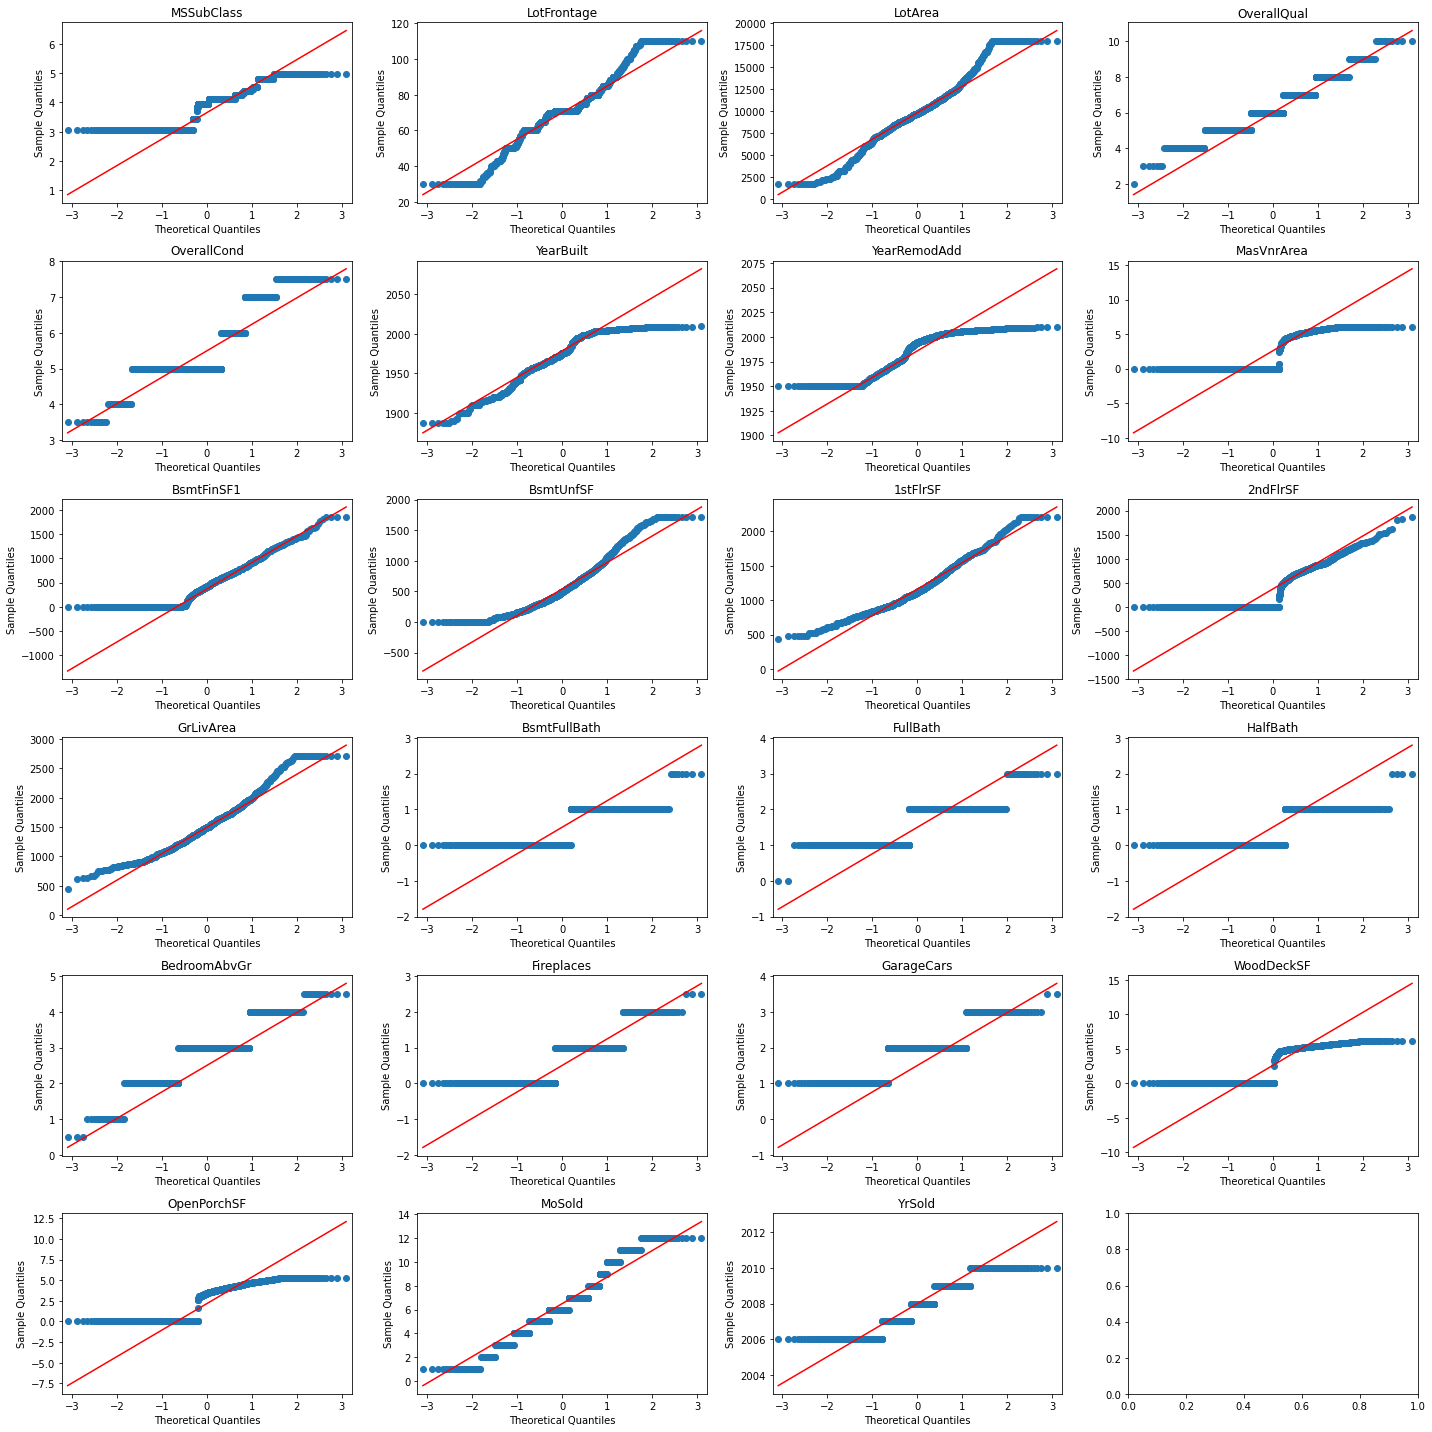

########################################################################################################
############################################## NORMALITY ###############################################
// shapiro threshold: 0.01
* W_Statistic=0.850, p=0.00000000
  MSSubClass does not look Gaussian (reject H0)
* W_Statistic=0.965, p=0.00000000
  LotFrontage does not look Gaussian (reject H0)
* W_Statistic=0.977, p=0.00000000
  LotArea does not look Gaussian (reject H0)
* W_Statistic=0.942, p=0.00000000
  OverallQual does not look Gaussian (reject H0)
* W_Statistic=0.798, p=0.00000000
  OverallCond does not look Gaussian (reject H0)
* W_Statistic=0.915, p=0.00000000
  YearBuilt does not look Gaussian (reject H0)
* W_Statistic=0.860, p=0.00000000
  YearRemodAdd does not look Gaussian (reject H0)
* W_Statistic=0.712, p=0.00000000
  MasVnrArea does not look Gaussian (reject H0)
* W_Statistic=0.902, p=0.00000000
  BsmtFinSF1 does not look Gaussian (reject H0)
* W_Statistic=0.929, p=0

In [33]:
# calling our preprocessing function
X_train_preprocessed, X_val_preprocessed = data_preprocessing(X_train, y_train, X_val, y_val, ordinal_cats, 
                                                              ordinal_encoding, nominal_cats, 
                                                              out_threshold=1.5, corr_threshold=.7, 
                                                              dup_threshold=.8, shapiro_threshold=.01, 
                                                              cols_threshold=0.6, rows_threshold=0.06)

# transforming the response variable to follow normal distribution
y_train_transformed = np.log(y_train)
y_val_transformed = np.log(y_val)

#### `4.1.1` LinearRegression Model *(data-preprocessed)*

In [34]:
linear_model = create_model(X_train_preprocessed, y_train_transformed, 'linear')
evaluate_model(y_val_transformed, X_val_preprocessed, linear_model)

,MSE,RMSE,MAE,MAPE,RAE,R-square,Adj-R
0,0.018582,0.136316,0.08588,0.721248,0.279478,0.884541,0.816955


#### `4.1.2` Ridge Model with different values of alpha *(data-preprocessed)*

In [35]:
ridge_models = []
for a in np.arange(0, 1, 0.1):
    ridge_models.append(create_model(X_train_preprocessed, y_train_transformed, 'ridge', alpha=a))
    
ridge_metrics = evaluate_models(y_val_transformed, X_val_preprocessed, ridge_models)
ridge_metrics.sort_values(by=['MSE']).head(3)

,alpha,MSE,RMSE,MAE,MAPE,RAE,R-square,Adj-R
9,0.9,0.018353,0.135473,0.085341,0.716985,0.277725,0.885966,0.819214
8,0.8,0.018358,0.135492,0.085345,0.717011,0.277740,0.885934,0.819163
7,0.7,0.018366,0.135520,0.085358,0.717101,0.277780,0.885886,0.819088


#### `4.1.3` Lasso Model with different values of alpha *(data-preprocessed)*

In [36]:
lasso_models = []
for a in np.arange(0, 1, 0.1):
    lasso_models.append(create_model(X_train_preprocessed, y_train_transformed, 'lasso', alpha=a))
    
lasso_metrics = evaluate_models(y_val_transformed, X_val_preprocessed, lasso_models)
lasso_metrics.sort_values(by=['MSE']).head(3)

,alpha,MSE,RMSE,MAE,MAPE,RAE,R-square,Adj-R
0,0.0,0.018582,0.136315,0.085886,0.721300,0.279500,0.884543,0.816959
1,0.1,0.104096,0.322639,0.238674,1.988005,0.776717,0.353205,-0.025407
2,0.2,0.161743,0.402173,0.309664,2.577181,1.007741,-0.004979,-0.593260


### `4.2` Cleaning our data from Multi-Collinearity and Insignificant Features

In [37]:
cols_with_high_vif = handle_vif(X_train_preprocessed, 10)

X_train_cleaned = drop_vif(X_train_preprocessed, cols_with_high_vif)
X_val_cleaned = drop_vif(X_val_preprocessed, cols_with_high_vif)

### Code from labs to get insignificant features

In [38]:
# add intercept term
X_train_cleaned_with_intercept = add_constant(X_train_cleaned)

significant_feats_df = X_train_cleaned_with_intercept

LRresult = (OLS(y_train_transformed.values, X_train_cleaned_with_intercept).fit().summary2().tables[1]).reset_index().rename(columns = {'index' : 'feature_name'})

insignificant_feats_ls = []

# if the results contain an insignificant feature (a feature with p-value > 0.05), 
# then we can drop it form the model and re-calculate the summary table
while LRresult['P>|t|'].max() > 0.05:
    # get the feature with the max p-value (the least significance for the model)
    insignificant_feat = LRresult[LRresult['P>|t|'] == LRresult['P>|t|'].max()][['feature_name']].values[0, 0]
    insignificant_feats_ls.append(insignificant_feat)
    significant_feats_df = significant_feats_df.drop(columns=[insignificant_feat])
    LRresult = (OLS(y_train_transformed.values, significant_feats_df).fit().summary2().tables[1]).reset_index().rename(columns = {'index' : 'feature_name'})

#insignificant_feats_ls

In [39]:
X_train_significant = X_train_cleaned.drop(columns=insignificant_feats_ls)
X_val_significant = X_val_cleaned.drop(columns=insignificant_feats_ls)

#### `4.2.1` LinearRegression Model

In [40]:
linear_model = create_model(X_train_significant, y_train_transformed, 'linear')
evaluate_model(y_val_transformed, X_val_significant, linear_model)

,MSE,RMSE,MAE,MAPE,RAE,R-square,Adj-R
0,0.017531,0.132407,0.086875,0.729631,0.282717,0.891069,0.875781


#### `4.2.2` Ridge Model

In [41]:
ridge_models = []
for a in np.arange(0, 1, 0.1):
    ridge_models.append(create_model(X_train_significant, y_train_transformed, 'ridge', alpha=a))
    
ridge_metrics = evaluate_models(y_val_transformed, X_val_significant, ridge_models)
ridge_metrics.sort_values(by=['MSE']).head(3)

,alpha,MSE,RMSE,MAE,MAPE,RAE,R-square,Adj-R
0,0.0,0.017531,0.132407,0.086875,0.729631,0.282717,0.891069,0.875781
1,0.1,0.017549,0.132474,0.086876,0.729632,0.282719,0.890958,0.875654
2,0.2,0.017569,0.132548,0.086881,0.729672,0.282736,0.890836,0.875515


#### `4.2.3` Lasso Model

In [42]:
lasso_models = []
for a in np.arange(0, 1, 0.1):
    lasso_models.append(create_model(X_train_significant, y_train_transformed, 'lasso', alpha=a))
    
lasso_metrics = evaluate_models(y_val_transformed, X_val_significant, lasso_models)
lasso_metrics.sort_values(by=['MSE']).head(3)

,alpha,MSE,RMSE,MAE,MAPE,RAE,R-square,Adj-R
0,0.0,0.017531,0.132407,0.086875,0.729631,0.282717,0.891069,0.875781
1,0.1,0.108586,0.329523,0.243430,2.028265,0.792195,0.325309,0.230616
2,0.2,0.161743,0.402173,0.309664,2.577181,1.007741,-0.004979,-0.146029


### `4.3` Basis expansion

In [43]:
poly = PolynomialFeatures(degree=2)
poly.fit(X_train_significant)
X_train_poly = poly.transform(X_train_significant)
X_val_poly = poly.transform(X_val_significant)

#### `4.3.1` LinearRegression Model

In [44]:
poly_feats_linear_reg = LinearRegression()
poly_model = create_model(X_train_poly, y_train_transformed, 'linear')
evaluate_model(y_val_transformed, X_val_poly, poly_model)

,MSE,RMSE,MAE,MAPE,RAE,R-square,Adj-R
0,5.567506e+16,2.359556e+08,5.389250e+07,4.612400e+08,1.753823e+08,-3.459336e+17,2.097545e+17


#### `4.3.1` Ridge Model

In [45]:
ridge_models = []
for a in np.arange(0, 1, 0.1):
    ridge_models.append(create_model(X_train_poly, y_train_transformed, 'ridge', alpha=a))
    
ridge_metrics = evaluate_models(y_val_transformed, X_val_poly, ridge_models)
ridge_metrics.sort_values(by=['MSE']).head(3)

,alpha,MSE,RMSE,MAE,MAPE,RAE,R-square,Adj-R
9,0.9,0.019629,0.140105,0.093886,0.788179,0.305533,0.878034,1.073953
8,0.8,0.019821,0.140785,0.094377,0.792266,0.307133,0.876846,1.074673
7,0.7,0.020051,0.141603,0.095007,0.797513,0.309181,0.875412,1.075543


#### `4.3.2` Lasso Model

In [46]:
lasso_models = []
for a in np.arange(0, 1, 0.1):
    lasso_models.append(create_model(X_train_poly, y_train_transformed, 'lasso', alpha=a))
    
lasso_metrics = evaluate_models(y_val_transformed, X_val_poly, lasso_models)
lasso_metrics.sort_values(by=['MSE']).head(3)

,alpha,MSE,RMSE,MAE,MAPE,RAE,R-square,Adj-R
0,0.0,0.044171,0.210169,0.135554,1.130201,0.441133,0.725547,1.166413
1,0.1,0.053582,0.231477,0.162412,1.360365,0.528536,0.667075,1.201867
2,0.2,0.071079,0.266606,0.191594,1.601398,0.623503,0.558357,1.267787


# CONCLUSION
1. All models with basis-expansion got an (adjusted R-square > 1) as number of features increases.
3. Models with only data-preprocessed performs a slightly better than linear one with (ridge model and alpha=0.9)
2. All models without insignificant features and without multicollinearity performs better than with only data-preprocessed.
3. Models without insignificant features and without multicollinearity all with ridge and lasso got the same score with alpha equals zero (alpha=0) and I did not catch why after I added a regularization term is the same as without it. ????
4. Finally the best models over all was that ones without insignificant features and without multicollinearity.

| alpha |   MSE  |    R   | ADJ(R) |            Model           |
|:-----:|:------:|:------:|:------:|:--------------------------:|
|   --  | 0.0185 | 0.8845 | 0.8169 | Linear + data-preprocessed |
|  0.9  | 0.0183 | 0.8859 | 0.8192 |  Ridge + data-preprocessed |

| alpha |   MSE  |    R   | ADJ(R) |              Model              |
|:-----:|:------:|:------:|:------:|:-------------------------------:|
|   --  | 0.0175 | 0.8910 | 0.8757 | Linear + data-cleaned (vif + p) |
|  0.0  | 0.0175 | 0.8910 | 0.8757 |  Ridge + data-cleaned (vif + p) |
|  0.0  | 0.0175 | 0.8910 | 0.8757 |  Lasso + data-cleaned (vif + p) |